In [1]:
# ============================================================
#  环境配置
#  - Colab 用户：取消注释下方 Colab 区块，注释掉 Local 区块
#  - 本地 Jupyter 用户：直接运行 Local 区块
# ============================================================

# ── Colab 环境（取消注释后运行） ──
# !pip install torch==2.10.0 torchvision==0.25.0 -q
# !pip install matplotlib==3.9.4 numpy==1.26.4 -q
!pip install torch torchvision matplotlib numpy -q
# ── 本地 Jupyter 环境 ──
# import subprocess, sys
# def _install(pkg):
#     subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

# _install("torch==2.10.0")
# _install("torchvision==0.25.0")
# _install("matplotlib==3.9.4")
# _install("numpy==1.26.4")

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# ResNet 从零到一：源代码实现 vs 简洁实现

基于论文 *Deep Residual Learning for Image Recognition* (He et al., 2016)，
用 **图像分类** 任务演示 ResNet 的核心架构——残差连接如何解决深度网络的退化问题。

本 Notebook 包含两种实现，使用 **相同的超参数和数据**：

| | 实现 A — 源代码实现 | 实现 B — 简洁实现 |
|---|---|---|
| 核心思路 | 手写 BasicBlock + 逐层组装，含公式推导 | 调用 `torchvision.models.resnet18` |
| 代码量 | ~80 行 | ~10 行 |
| 适合场景 | 深入理解残差学习、面试准备 | 快速原型、工程落地 |
| 架构 | CIFAR-10 适配版 ResNet-18 | 同左（修改 conv1 + 移除 maxpool） |

## 1. 数据准备

使用 **CIFAR-10** 数据集（10 类彩色图片，32×32）。
论文中 ResNet 在 CIFAR-10 上的实验是核心结果之一（ResNet-110 达到 6.43% 错误率）。

| 属性 | 值 |
|------|-----|
| 图像尺寸 | 32×32×3 (RGB) |
| 类别数 | 10 |
| 训练子集 | 5000 |
| 测试子集 | 1000 |

**为什么不 Resize 到 224×224？** CIFAR-10 原始尺寸仅 32×32，放大到 224 会引入大量插值伪影且极大增加计算量。论文中也直接使用 32×32 输入，但将 conv1 从 7×7/stride=2 改为 3×3/stride=1，并移除 maxpool。

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),   # 数据增强：随机裁剪
    transforms.RandomHorizontalFlip(),      # 数据增强：随机水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),   # CIFAR-10 均值
                         (0.2470, 0.2435, 0.2616))    # CIFAR-10 标准差
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

full_train = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
full_test = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

NUM_TRAIN, NUM_TEST = 5000, 1000
train_dataset = Subset(full_train, range(NUM_TRAIN))
test_dataset = Subset(full_test, range(NUM_TEST))

class_names = full_train.classes
print(f'训练集: {len(train_dataset)}, 测试集: {len(test_dataset)}')
print(f'类别: {class_names}')

100%|██████████| 170M/170M [00:05<00:00, 31.0MB/s]


训练集: 5000, 测试集: 1000
类别: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


batch shape: torch.Size([128, 3, 32, 32]), labels: torch.Size([128])


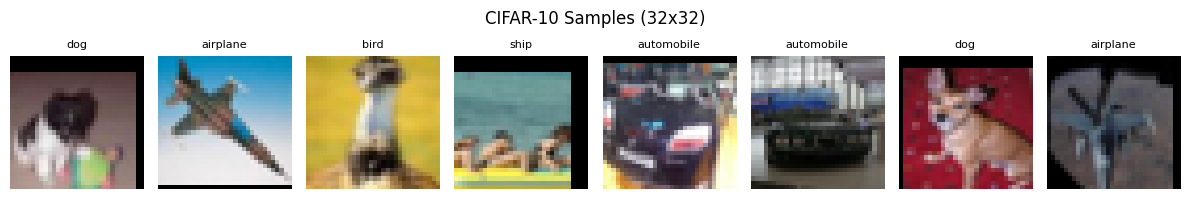

In [4]:
BATCH_SIZE = 128
train_iter = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, drop_last=True)
test_iter = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

# 验证 batch 形状
images, labels = next(iter(train_iter))
print(f'batch shape: {images.shape}, labels: {labels.shape}')  # (128, 3, 32, 32), (128,)

# 可视化前 8 张样本（反归一化）
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, ax in enumerate(axes):
    img = images[i] * std + mean  # 反归一化
    ax.imshow(img.permute(1, 2, 0).clamp(0, 1).numpy())
    ax.set_title(class_names[labels[i]], fontsize=8)
    ax.axis('off')
plt.suptitle('CIFAR-10 Samples (32x32)')
plt.tight_layout(); plt.show()

## 2. 共享组件

超参数、训练循环、评估函数——两种实现共用。

In [5]:
# ── 超参数（两种实现共用，集中管理） ──
IN_CHANNELS = 3       # CIFAR-10 RGB
NUM_CLASSES = 10      # CIFAR-10 10 类
LR          = 0.01    # 论文初始学习率
MOMENTUM    = 0.9     # 论文动量值
WEIGHT_DECAY = 1e-4   # 论文权重衰减
NUM_EPOCHS  = 10      # CPU 友好（论文训练 ~160 epochs on GPU）

In [6]:
def train_model(net, train_iter, test_iter, num_epochs, lr, momentum, weight_decay, device):
    """通用训练函数，使用论文中的 SGD + Momentum。"""
    net.to(device)
    optimizer = torch.optim.SGD(
        net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    train_losses, test_accs = [], []

    for epoch in range(num_epochs):
        net.train()
        total_loss, total_samples = 0.0, 0
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)                              # (batch, num_classes)
            loss = loss_fn(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * y.numel()
            total_samples += y.numel()

        avg_loss = total_loss / total_samples
        train_losses.append(avg_loss)

        acc = evaluate(net, test_iter, device)
        test_accs.append(acc)
        print(f'Epoch {epoch+1:2d}/{num_epochs}, '
              f'Loss: {avg_loss:.4f}, Test Acc: {acc:.2%}')

    return train_losses, test_accs


def evaluate(net, data_iter, device):
    """计算分类准确率。"""
    net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            preds = net(X).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.numel()
    return correct / total


def plot_results(losses, accs, title=''):
    """绘制 Loss 曲线和 Accuracy 曲线。"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(losses); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax2.plot(accs); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy')
    ax2.set_title('Test Accuracy')
    if title: fig.suptitle(title, fontsize=12)
    plt.tight_layout(); plt.show()

---
# 3. 实现 A — 源代码实现（From Scratch）

逐组件手写 ResNet-18 的 BasicBlock 和完整网络，适配 CIFAR-10 (32×32) 输入。

> **数据流**：输入图像 → 3×3 Conv → BN → ReLU → 4 个 Stage（每 Stage 含 2 个 BasicBlock） → 全局平均池化 → FC → logits

### 3.1 残差块（BasicBlock）

**残差学习核心公式**：网络不直接学习目标映射 $\mathcal{H}(x)$，而是学习残差 $\mathcal{F}(x) = \mathcal{H}(x) - x$，最终输出为：

$$\mathcal{H}(x) = \mathcal{F}(x) + x$$

**为什么学习残差更容易？** 如果最优映射接近恒等映射，让 $\mathcal{F}(x) \to 0$ 比从头拟合 $\mathcal{H}(x) = x$ 要容易得多。

**BasicBlock 结构**：两层 3×3 卷积，每层后接 BN，ReLU 在 shortcut 相加**之后**施加。

$$\text{out} = \text{ReLU}\Big(\underbrace{\text{BN}\big(\text{Conv}_{3\times3}(\text{ReLU}(\text{BN}(\text{Conv}_{3\times3}(x))))\big)}_{\mathcal{F}(x)} + \underbrace{x \text{ 或 } W_s x}_{\text{shortcut}}\Big)$$

**投影快捷连接（Projection Shortcut）**：当输入输出维度不一致时（通道数变化 或 stride > 1），用 1×1 卷积 + BN 对齐维度：

| 快捷连接类型 | 条件 | 实现 | 额外参数 |
|---|---|---|---|
| Identity | 输入输出维度一致 | `out += x` | 0 |
| Projection | 通道数 或 空间尺寸变化 | `out += Conv1x1(BN(x))` | 有 |

In [7]:
class BasicBlock(nn.Module):
    """基本残差块：两层 3×3 卷积 + 快捷连接。"""
    expansion = 1  # 输出通道 = planes * expansion

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        # 残差分支 F(x)
        # Conv1: (batch, in_ch, H, W) → (batch, out_ch, H/stride, W/stride)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Conv2: (batch, out_ch, H', W') → (batch, out_ch, H', W')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # 快捷连接：当维度不匹配时，用 1×1 卷积投影
        self.downsample = downsample

    def forward(self, x):
        identity = x                          # 保存输入

        out = self.conv1(x)                   # (batch, out_ch, H', W')
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)                 # (batch, out_ch, H', W')
        out = self.bn2(out)                   # F(x) 完成

        if self.downsample is not None:
            identity = self.downsample(x)     # 对齐维度：1×1 Conv + BN

        out += identity                       # H(x) = F(x) + x
        out = self.relu(out)                  # 最终 ReLU
        return out

### 3.2 残差连接与梯度传播

**无残差连接**时，梯度通过链式法则逐层相乘，容易消失：

$$\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial f} \cdot \frac{\partial f}{\partial g} \cdot \frac{\partial g}{\partial x}$$

**有残差连接**时，输出为 $f(g(x)) + g(x)$，梯度变为：

$$\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial \mathcal{H}} \cdot \left(\frac{\partial \mathcal{F}}{\partial x} + 1\right)$$

**+1 项**来自 identity shortcut，保证即使 $\frac{\partial \mathcal{F}}{\partial x}$ 很小，梯度也不会消失——这是一条"梯度高速公路"。

### 3.3 ResNet-18 完整组装

**CIFAR-10 适配**：标准 ResNet 的 conv1（7×7, stride=2）+ maxpool 会将 32×32 压缩到 8×8，丢失大量信息。
CIFAR-10 版本改为 **3×3, stride=1, 无 maxpool**，保持 32×32 分辨率进入残差块。

**ResNet-18 逐层尺寸变化**（输入 $3 \times 32 \times 32$）：

| Stage | 操作 | 输出尺寸 | Block 数 |
|-------|------|---------|---------|
| conv1 | Conv2d 3×3, s=1 + BN + ReLU | 64×32×32 | - |
| layer1 | BasicBlock×2, s=1 | 64×32×32 | 2 |
| layer2 | BasicBlock×2, s=2 | 128×16×16 | 2 |
| layer3 | BasicBlock×2, s=2 | 256×8×8 | 2 |
| layer4 | BasicBlock×2, s=2 | 512×4×4 | 2 |
| avgpool | AdaptiveAvgPool2d(1,1) | 512×1×1 | - |
| fc | Linear | 10 | - |

In [8]:
class ResNet18Scratch(nn.Module):
    """ResNet-18 源代码实现，适配 CIFAR-10 (32×32) 输入。"""

    def __init__(self, block=BasicBlock, layers=(2, 2, 2, 2),
                 in_channels=IN_CHANNELS, num_classes=NUM_CLASSES):
        super().__init__()
        self.in_channels = 64  # 当前通道数，随 _make_layer 递增

        # ===== Stem：3×3 Conv（替代 ImageNet 版的 7×7） =====
        # (batch, 3, 32, 32) → (batch, 64, 32, 32)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # 注意：CIFAR-10 版本不使用 maxpool

        # ===== 4 个 Stage =====
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)  # 32×32
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  # 16×16
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  # 8×8
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  # 4×4

        # ===== 分类头 =====
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # (batch, 512, 1, 1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # 权重初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """构建一个 Stage：第一个 block 可能下采样，后续 block 保持尺寸。"""
        downsample = None
        # 当 stride > 1 或通道数变化时，需要投影快捷连接
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        # 第一个 block：可能下采样
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        # 后续 blocks：保持尺寸
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Stem
        x = self.relu(self.bn1(self.conv1(x)))  # (batch, 64, 32, 32)
        # 4 Stages
        x = self.layer1(x)                       # (batch, 64, 32, 32)
        x = self.layer2(x)                       # (batch, 128, 16, 16)
        x = self.layer3(x)                       # (batch, 256, 8, 8)
        x = self.layer4(x)                       # (batch, 512, 4, 4)
        # 分类头
        x = self.avgpool(x)                      # (batch, 512, 1, 1)
        x = torch.flatten(x, 1)                  # (batch, 512)
        x = self.fc(x)                           # (batch, num_classes)
        return x

In [9]:
# 验证模型结构与输出形状
net_a = ResNet18Scratch()
dummy = torch.randn(2, IN_CHANNELS, 32, 32)
out = net_a(dummy)
print(f'输入: {dummy.shape} → 输出: {out.shape}')   # (2, 10)
total_params = sum(p.numel() for p in net_a.parameters())
print(f'总参数量: {total_params:,}')

输入: torch.Size([2, 3, 32, 32]) → 输出: torch.Size([2, 10])
总参数量: 11,173,962


### 3.4 训练实现 A

Training Implementation A - From Scratch
Epoch  1/10, Loss: 2.0977, Test Acc: 26.90%
Epoch  2/10, Loss: 1.7689, Test Acc: 34.80%
Epoch  3/10, Loss: 1.6637, Test Acc: 41.40%
Epoch  4/10, Loss: 1.5259, Test Acc: 43.50%
Epoch  5/10, Loss: 1.4580, Test Acc: 42.70%
Epoch  6/10, Loss: 1.3865, Test Acc: 48.80%
Epoch  7/10, Loss: 1.3160, Test Acc: 47.30%
Epoch  8/10, Loss: 1.2431, Test Acc: 46.80%
Epoch  9/10, Loss: 1.2347, Test Acc: 48.40%
Epoch 10/10, Loss: 1.1835, Test Acc: 54.40%


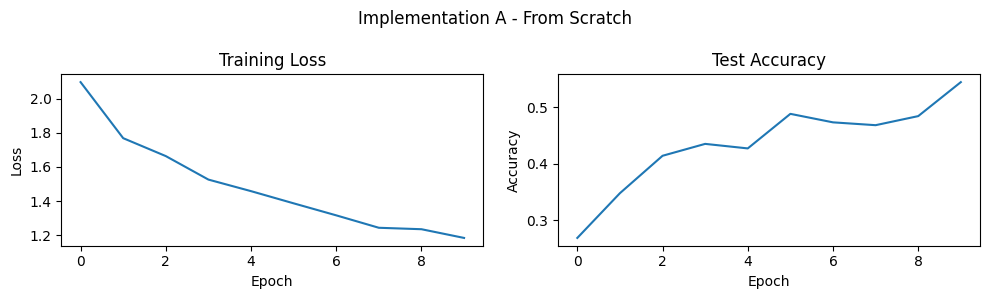

In [10]:
net_a = ResNet18Scratch()
print('Training Implementation A - From Scratch')
losses_a, accs_a = train_model(
    net_a, train_iter, test_iter,
    NUM_EPOCHS, LR, MOMENTUM, WEIGHT_DECAY, device)
plot_results(losses_a, accs_a, 'Implementation A - From Scratch')

---
# 4. 实现 B — 简洁实现（Concise）

直接调用 `torchvision.models.resnet18`，修改首层卷积和分类头以适配 CIFAR-10。

| 源代码实现 | 简洁实现 (`torchvision.models`) |
|---|---|
| `BasicBlock` | 内置 `BasicBlock`（结构相同） |
| `ResNet18Scratch._make_layer` | `ResNet._make_layer`（内置） |
| `conv1` 3×3 + 无 maxpool | 修改 `model.conv1` + `model.maxpool = Identity()` |
| `self.fc` | 通过 `num_classes=10` 直接设置 |

In [11]:
from torchvision import models

net_b = models.resnet18(num_classes=NUM_CLASSES)
# 适配 CIFAR-10 (32×32)：将 7×7/stride=2 改为 3×3/stride=1
net_b.conv1 = nn.Conv2d(IN_CHANNELS, 64, kernel_size=3,
                        stride=1, padding=1, bias=False)
# 移除 maxpool（32×32 太小，不能再下采样）
net_b.maxpool = nn.Identity()

print(net_b)
total_params_b = sum(p.numel() for p in net_b.parameters())
print(f'\n总参数量: {total_params_b:,}')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

### 4.1 训练实现 B

Training Implementation B - Concise
Epoch  1/10, Loss: 2.1147, Test Acc: 21.20%
Epoch  2/10, Loss: 1.7856, Test Acc: 32.80%
Epoch  3/10, Loss: 1.6381, Test Acc: 39.40%
Epoch  4/10, Loss: 1.5394, Test Acc: 43.80%
Epoch  5/10, Loss: 1.4403, Test Acc: 43.00%
Epoch  6/10, Loss: 1.3687, Test Acc: 44.20%
Epoch  7/10, Loss: 1.3142, Test Acc: 52.60%
Epoch  8/10, Loss: 1.2321, Test Acc: 50.20%
Epoch  9/10, Loss: 1.2126, Test Acc: 53.00%
Epoch 10/10, Loss: 1.1079, Test Acc: 51.10%


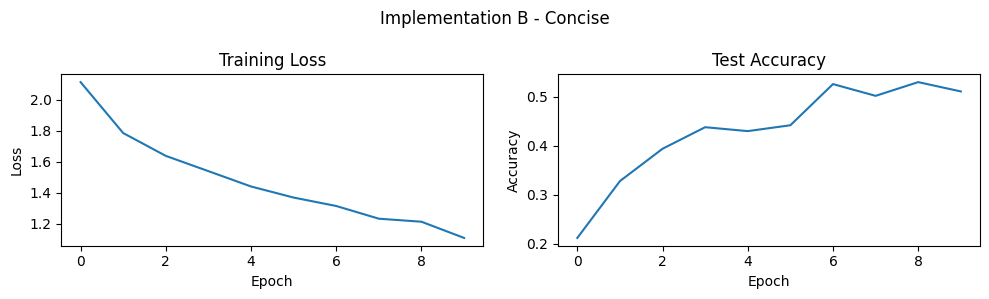

In [12]:
print('Training Implementation B - Concise')
losses_b, accs_b = train_model(
    net_b, train_iter, test_iter,
    NUM_EPOCHS, LR, MOMENTUM, WEIGHT_DECAY, device)
plot_results(losses_b, accs_b, 'Implementation B - Concise')

---
# 5. 结果对比

两种实现使用完全相同的超参数和数据，架构也完全等价（均为 CIFAR-10 适配的 ResNet-18）。

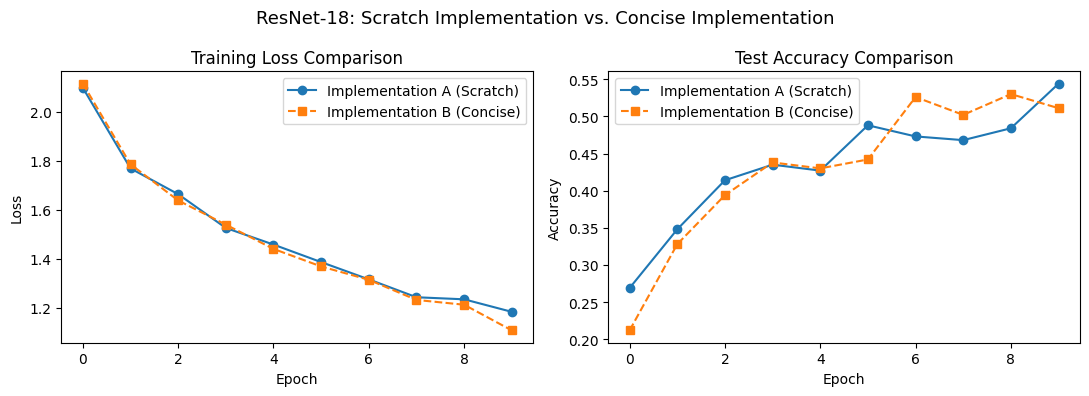

Implementation A Final Acc: 54.40%
Implementation B Final Acc: 51.10%


In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

ax1.plot(losses_a, 'o-', label='Implementation A (Scratch)')
ax1.plot(losses_b, 's--', label='Implementation B (Concise)')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Comparison'); ax1.legend()

ax2.plot(accs_a, 'o-', label='Implementation A (Scratch)')
ax2.plot(accs_b, 's--', label='Implementation B (Concise)')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy')
ax2.set_title('Test Accuracy Comparison'); ax2.legend()

plt.suptitle('ResNet-18: Scratch Implementation vs. Concise Implementation', fontsize=13)
plt.tight_layout(); plt.show()

print(f'Implementation A Final Acc: {accs_a[-1]:.2%}')
print(f'Implementation B Final Acc: {accs_b[-1]:.2%}')

---
# 附录 A：残差块梯度流可视化

验证残差连接对梯度传播的作用：比较有/无 shortcut 时各层梯度的范数。

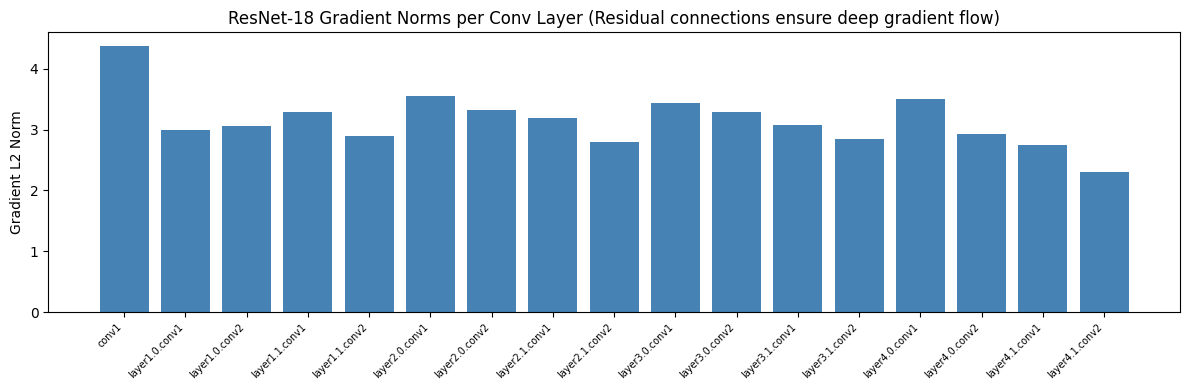

In [14]:
# 提取各层卷积权重的梯度范数
net_a.to(device)
net_a.eval()
net_a.zero_grad(set_to_none=True)  # 清除训练残留梯度

sample_X, sample_y = next(iter(train_iter))
sample_X, sample_y = sample_X.to(device), sample_y.to(device)

loss = nn.CrossEntropyLoss()(net_a(sample_X), sample_y)
loss.backward()

# 收集各卷积层的梯度 L2 范数
grad_norms = []
layer_names = []
for name, param in net_a.named_parameters():
    if 'conv' in name and 'weight' in name and param.grad is not None:
        grad_norms.append(param.grad.norm().item())
        layer_names.append(name.replace('.weight', ''))

plt.figure(figsize=(12, 4))
plt.bar(range(len(grad_norms)), grad_norms, color='steelblue')
plt.xticks(range(len(layer_names)), layer_names, rotation=45, ha='right', fontsize=7)
plt.ylabel('Gradient L2 Norm')
plt.title('ResNet-18 Gradient Norms per Conv Layer (Residual connections ensure deep gradient flow)')
plt.tight_layout(); plt.show()

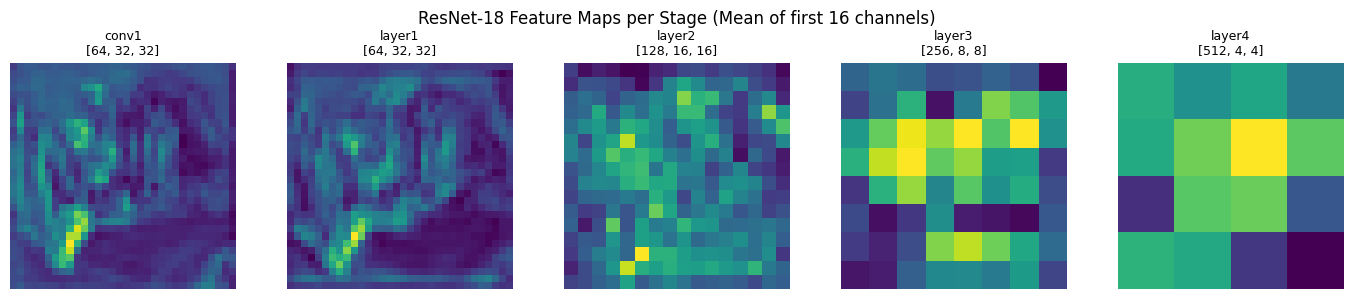

In [15]:
# 可视化各 Stage 的特征图
sample_img = test_dataset[0][0].unsqueeze(0).to(device)  # (1, 3, 32, 32)
net_a.eval()

feature_maps = {}
with torch.no_grad():
    x = net_a.relu(net_a.bn1(net_a.conv1(sample_img)))
    feature_maps['conv1'] = x.cpu()
    x = net_a.layer1(x); feature_maps['layer1'] = x.cpu()
    x = net_a.layer2(x); feature_maps['layer2'] = x.cpu()
    x = net_a.layer3(x); feature_maps['layer3'] = x.cpu()
    x = net_a.layer4(x); feature_maps['layer4'] = x.cpu()

fig, axes = plt.subplots(1, 5, figsize=(14, 3))
for idx, (name, fmap) in enumerate(feature_maps.items()):
    ax = axes[idx]
    # 显示前 16 个通道的均值
    ax.imshow(fmap[0, :16].mean(dim=0), cmap='viridis')
    ax.set_title(f'{name}\n{list(fmap.shape[1:])}', fontsize=9)
    ax.axis('off')
plt.suptitle('ResNet-18 Feature Maps per Stage (Mean of first 16 channels)', fontsize=12)
plt.tight_layout(); plt.show()

---
# 附录 B：面试拓展

## 高频面试题

**Q1: ResNet 解决了什么核心问题？**

**退化问题（Degradation）**，而非过拟合。实验表明 56 层 Plain 网络的**训练误差和测试误差均高于** 20 层网络。这说明深层网络的优化本身出了问题——加深后训练误差反而上升。ResNet 通过残差学习使网络深度首次突破 100 层甚至 1000 层。

---

**Q2: 残差学习的核心公式是什么？为什么学习残差更容易？**

$\mathcal{H}(x) = \mathcal{F}(x) + x$，其中 $\mathcal{F}(x) = \mathcal{H}(x) - x$ 是残差函数。

如果最优映射接近恒等映射，让 $\mathcal{F}(x) \to 0$ 远比让一叠非线性层拟合 $\mathcal{H}(x) = x$ 容易。类比："修改一句话比从头重写容易"——网络只需学习在输入基础上的**微小调整**。

---

**Q3: Skip Connection 有哪两种类型？**

| 类型 | 条件 | 实现 | 额外参数 |
|------|------|------|---------|
| **Identity** | 输入输出维度一致 | `out += x` | 0 |
| **Projection** | 维度不一致（通道数/空间尺寸变化） | `out += Conv1x1+BN(x)` | 有 |

论文还提到了 zero-padding 方案（对新增通道填零），不引入额外参数但效果不如 Projection。

---

**Q4: 残差连接如何缓解梯度消失？**

反向传播时梯度为：$\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial \mathcal{H}} \cdot \left(\frac{\partial \mathcal{F}}{\partial x} + 1\right)$

**+1 项**来自 identity shortcut，保证即使 $\frac{\partial \mathcal{F}}{\partial x}$ 很小，梯度也不消失——这是一条"梯度高速公路"。

注意：退化问题的根因不完全是梯度消失（BN 已部分解决），而是深层网络的优化困难。残差连接同时缓解了这两个问题。

---

**Q5: Bottleneck 设计的动机是什么？**

在不增加过多计算量的前提下构建更深网络。结构：`1×1降维 → 3×3卷积 → 1×1升维`。

- 第一个 1×1 将通道数压缩 4 倍（如 256→64）
- 中间 3×3 在低维空间做卷积（计算量大幅减少）
- 最后 1×1 恢复到原通道数

ResNet-50 (Bottleneck) 参数量 25.6M 仅比 ResNet-34 (BasicBlock) 的 21.8M 多 ~18%，但深度和表达力大幅提升。

---

**Q6: ResNet 与 VGG 的核心区别？**

| 对比维度 | VGG-19 | ResNet-152 |
|---------|--------|-----------|
| 层数 | 19 | 152（深 8 倍） |
| 参数量 | ~144M | ~60M（少 58%） |
| 残差连接 | 无 | 有 |
| 退化问题 | 超过 ~20 层后退化 | 无 |
| ImageNet Top-5 | ~7.3% | ~3.6% |

核心：VGG 直接学习 $\mathcal{H}(x)$，ResNet 学习 $\mathcal{F}(x) = \mathcal{H}(x) - x$。

---

**Q7: ResNet 与 DenseNet 的区别？**

| 对比维度 | ResNet | DenseNet |
|---------|--------|---------|
| 跨层连接 | **逐元素相加** | **通道拼接** |
| 信息复用 | 隐式（残差被加到输入上） | 显式（所有前层特征都保留） |
| 参数效率 | 中等 | 更高（每层可用更窄通道） |
| 内存开销 | 较低 | 较高（保存所有中间特征图） |

---

**Q8: ResNet 与 Highway Network 的区别？**

Highway Network 使用门控机制：$y = T(x) \cdot H(x) + C(x) \cdot x$

ResNet 可视为 $T(x) = 1, C(x) = 1$ 的特例：$y = F(x) + x$

实验表明 ResNet 效果更好——保持梯度通路**完全畅通**（无门控衰减）优于引入可学习的门控。简单性在此胜出。

---

**Q9: 什么是 Pre-activation ResNet？**

He et al. 2016 改进版，改变 BN/ReLU 与 Conv 的顺序：

| | 标准 ResNet | Pre-activation |
|---|---|---|
| 顺序 | Conv→BN→ReLU | **BN→ReLU→Conv** |
| 加法后 | 经 ReLU | **直接输出** |
| 恒等映射 | 不完美（经 ReLU 截断） | **完美恒等映射** |

Pre-activation 使 shortcut 是真正的恒等映射，信号在任意两层间无损传递。

---

**Q10: `zero_init_residual` 参数的作用？**

将每个残差分支最后一个 BN 的 $\gamma$ 初始化为 0。训练初期 $\mathcal{F}(x) = 0$，每个残差块退化为恒等映射，模拟了一个较浅的网络。随着训练进行，残差分支逐渐"生长"出有意义的特征变换。经验可提升 ~0.2-0.3% 精度。

---

## 延伸阅读与对比

| 对比维度 | VGG (2014) | ResNet (2015) | DenseNet (2017) |
|---------|------------|---------------|-----------------|
| 核心思想 | 深度 + 统一小核 | 残差连接 | 密集连接 |
| 跨层连接 | 无 | 加法 | 拼接 |
| 典型深度 | 16/19 | 18/34/50/101/152 | 121/169/201 |
| 参数量 | 138M (VGG-16) | 25M (ResNet-50) | 8M (DenseNet-121) |
| ImageNet Top-5 | 7.3% | 3.6% | 3.4% |

## 进阶探索方向

- **ResNeXt**：引入分组卷积（Cardinality 维度），在不增加复杂度的前提下提升表达力
- **SE-Net (Squeeze-and-Excitation)**：在残差块中加入通道注意力机制，动态调整通道权重
- **EfficientNet**：统一缩放深度、宽度和分辨率，用复合缩放系数平衡三者